# Linear-nonlinear Models of Neurons

In [1]:
#Initializer block
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sci
import scipy as sci
from scipy.io import loadmat
import pandas as pd
import math

import matplotlib.animation as animation
from pylab import *

from scipy.interpolate import interp1d
from scipy.stats import binned_statistic

In [2]:
mat = loadmat('contrast_response.mat')

spikeTimes = pd.DataFrame(mat["spikeTimes"]/2000) #units of seconds
contrasts = pd.DataFrame(mat["contrasts"])
stimulus = pd.DataFrame(mat["stimulus"])

## Problem 1: Find Spike-Triggered Average

### Problem 1a 

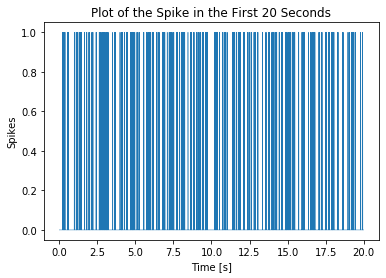

In [3]:
temp = [];
temp = pd.DataFrame(spikeTimes[8][0])
spikeIndex = []; #stores the index (the time when) the spikes occur

spikes = np.zeros(200000) #stores when the spikes occur amongst all possible times, [s/0.0005]; spike time converted to index
times = np.linspace(0,20,40000) #20 seconds

for i in range(len(temp[0])): #find instances of spikes
    spikes[int(temp[0][i]/0.0005)] = 1
    spikeIndex.append(temp[0][i]);

plt.plot(times,spikes[:40000],linewidth=0.5)
plt.xlabel("Time [s]")
plt.ylabel("Spikes")
plt.title("Plot of the Spike in the First 20 Seconds");

### Problem 1b

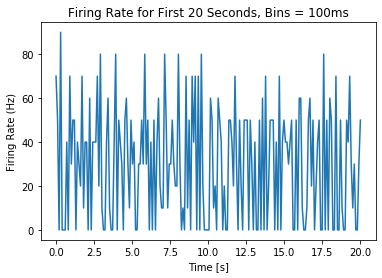

In [4]:
n, bins, c = plt.hist(spikeIndex[:595],bins=200); #100 ms time bins for all times up to 20 seconds
plt.close();

n = n/(100/1000) #firing rate; dividing by bin size

plt.figure()
plt.plot(np.linspace(0,20,len(n)),n)
plt.xlabel("Time [s]")
plt.ylabel("Firing Rate (Hz)")
plt.title("Firing Rate for First 20 Seconds, Bins = 100ms");

### Problem 1c 

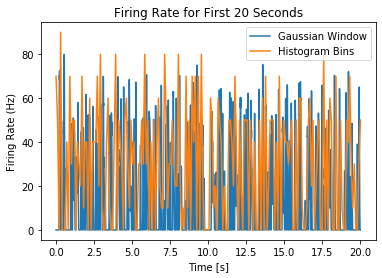

In [5]:
spikeys = np.zeros(200000) #stores when the spikes occur amongst all possible times, [s/0.0005]; spike time converted to index
spikeIndex = []; #stores the index (the time when) the spikes occur
times = np.linspace(0,20,40000) #20 seconds

for i in range(len(temp[0])): #find instances of spikes
    spikeys[int(temp[0][i]/0.0005)] = 1
    spikeIndex.append(temp[0][i]);

spikeys = pd.DataFrame(spikes,columns = ["Spikes [s/0.0005]"]) #dataframe for all times
spikeIndex = pd.DataFrame(spikeIndex,columns = ["Spike Times [s]"]) #data for when the spikes occur

"""
Running a rolling Gaussian window of length 100 ms (0.1 s) with a stdev of 35 ms (0.035 s)
"""
tempData = spikeys["Spikes [s/0.0005]"].rolling(100,win_type="gaussian",center=True).mean(std = 35)*1000
tempData = tempData.apply(np.nan_to_num)

plt.plot(times,tempData[:40000],label="Gaussian Window")
plt.plot(np.linspace(0,20,len(n)),n,label="Histogram Bins")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Firing Rate (Hz)")
plt.title("Firing Rate for First 20 Seconds");

### Problem 1d

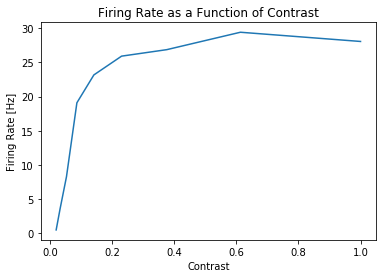

In [6]:
averageFiringRate = [];

for j in range(len(contrasts)):
    spikeIndex = []; #stores indices of spikes
    tempContrast = contrasts[0][j]
    tempSpikes = pd.DataFrame(spikeTimes[j][0])
    
    for i in range(len(tempSpikes[0])): #find instances of spikes
        spikeIndex.append(tempSpikes[0][i]);
        
    n, bins, c = plt.hist(spikeIndex,bins=1000); #100 ms time bins for the entire experiment
    plt.close();
    n = n*(1/0.1) #firing rate per bin, divided by bin size 100ms (0.1 s)
    averageFiringRate.append(np.mean(n))
    
plt.plot(contrasts,averageFiringRate)
plt.xlabel("Contrast");
plt.ylabel("Firing Rate [Hz]");
plt.title("Firing Rate as a Function of Contrast");

### Problem 1e 

In [7]:
"""
Function that inputs contrast and the spikeTimes [s] for that specific contrast
and then spits out the desired spike triggered average graph
"""
samplingRate = 0.0005

def plot_sta(contrast,spikeTimeContrast): 
    taus = np.linspace(0,1000,1001); #taus list [ms]
    
    n = np.mean(spikeTimeContrast["spikeTimes"]) #average number of spikes per trial
    summy = []; #stores the sum for each value of tau
    
    """
    Loop through all the values of tau. Nested loop through each of the spike times.
    Divide by n
    """
    for i in range(len(taus)): 
        summ = 0;
        for j in range(len(spikeTimeContrast)):
            index = spikeTimeContrast["spikeTimes"][j]/samplingRate
            tau = taus[i]/1000/samplingRate #convert to [s] and then divide by sampling rate
            if tau < index:
                summ += stimulus[0][int(index-tau)]*contrast #summation 
        summy.append((1/n)*summ) #append sum for the tau
    summy = list(map(lambda x: x/np.sqrt(sum(list(map(lambda x:x*x,summy)))),summy)) #normalize sum of squared values = 1
    
    labeler = str(round(contrast,2))
    plt.plot(taus,summy,label=labeler)
    plt.xlabel("Tau [ms]")
    plt.ylabel("Spike Triggered Average")

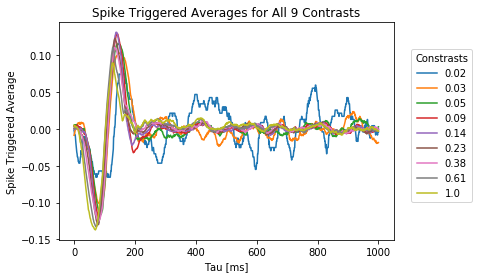

In [8]:
for i in range(len(contrasts[0])):
    plot_sta(contrasts[0][i],pd.DataFrame(spikeTimes[i][0],columns=["spikeTimes"]))
plt.title("Spike Triggered Averages for All 9 Contrasts")
plt.legend(bbox_to_anchor=(1.25, 0.9),title="Constrasts",fancybox=True);

### Part 1f

As the contrast gets higher, it seems as though the minimum and the maximum of the STA gets lower (the valley and peak of the STA gets lower). In addition, as the contrast gets higher, the STA curve becomes smoother; at lower STAs, the curve becomes rough. 

This suggests that for higher contrasts, the retinal ganglion cell responds faster since tau represents the time before firing.

## Problem 2: Static Nonlinearity
### Problem 2a & 2b

In [9]:
"""
Function that inputs contrast and the spikeTimes [s] for that specific contrast
and then returns the STA list
"""

#edit taus number

samplingRate = 0.0005

def return_sta(contrast,spikeTimeContrast): 
    taus = np.arange(0,1000,1);                          #taus list
    
    stimulusTemp = stimulus[0]*contrast
    length = len(spikeTimeContrast["spikeTimes"])        #length to divide by
    summy = [];                                          #stores the sum for each value of tau
    
    """
    Loop through all the values of tau. Nested loop through each of the spike times.
    Divide by n
    """
    for tau in taus: 
        summ = 0;
        for j in spikeTimeContrast["spikeTimes"]:
            
            if len(taus) < j:
                summ += stimulusTemp[int(j-tau)] #summation
        summy.append((1/length)*summ) #append sum for the tau
        
    summy = list(map(lambda x: x/np.sqrt(sum(list(map(lambda x:x*x,summy)))),summy)) #normalize sum of squared values = 1
    
    return summy

In [21]:
"""
Function that takes all values less than 0 and sets them to 0
"""
def zeroer(num):
    if num < 0:
        return 0
    else:
        return num

In [22]:
"""
Creating list of Gaussians to save time when running future runs
"""

#spikeTimesRaw = pd.DataFrame(mat["spikeTimes"]*20000)

gaussian_firing_list = [[]]*9

for i in range(len(gaussian_firing_list)):
    tempSpikeIndex = np.zeros(len(stimulus[0]))                              # list of empty zeros to store index of spike
    tempSpikeTime = pd.DataFrame(spikeTimes[i][0],columns=["Spike Index"])
    
    for j in range(len(tempSpikeTime["Spike Index"])):                       # makes spike train
        index = int(tempSpikeTime["Spike Index"][int(j)]/0.0005)             # find index 
        tempSpikeIndex[index] = 1                                                 # when spike occurs; spike train
    
    tempSpikeIndex = pd.DataFrame(tempSpikeIndex,columns = ["Spikes Index"]) # dataframe for all times
    
    tempGaussianData = tempSpikeIndex["Spikes Index"].rolling(200,win_type="gaussian").mean(std = 40)*1000
    tempGaussianData = tempGaussianData.apply(np.nan_to_num)
    gaussian_firing_list[i] = tempGaussianData

In [23]:
spikeyTimes = pd.DataFrame(mat["spikeTimes"]) #units of sample rate

In [24]:
"""
Creating list of sta's to save time when running future runs
"""

sta_list = [[]]*9

for i in range(len(sta_list)):
    tempContrast = contrasts[0][i]
    tempSpikeTime = pd.DataFrame(spikeyTimes[i][0],columns=["spikeTimes"])
    sta_list[i] = list(return_sta(tempContrast,tempSpikeTime))

In [25]:
"""
Find maximum value to rescale
"""

contrast = contrasts[0][8]                                        #contrast
spikeTime = pd.DataFrame(spikeTimes[8][0],columns=["spikeTimes"]) #spike times for that contrast
        
sta = sta_list[8]                                                 #calling for sta filter and reversing it                                                
sta = list(np.zeros(1200))+ sta                                   #padding
        
convolution = np.convolve(stimulus[0]*contrast,sta,'same')        #convolution 
scalingFactor = max(convolution)
print(scalingFactor)

#sta_list = list(map(lambda x: x*(1/scalingFactor,sta_list)))

17.336336231536663


In [26]:
"""
Do convolution
"""
##scaling_factor = max(convoluti)
def convolution_function(n):
    contrast = contrasts[0][n]                                        #contrast
    spikeTime = pd.DataFrame(spikeTimes[n][0],columns=["spikeTimes"]) #spike times for that contrast
        
    sta = sta_list[n]                                                 #calling for sta filter and reversing it                                                
    sta = list(np.zeros(1200))+ sta                                   #padding
        
    convolution = np.convolve(stimulus[0]*contrast,sta,'same')        #convolution  
    convolution = convolution*(1/scalingFactor)
    
    return convolution

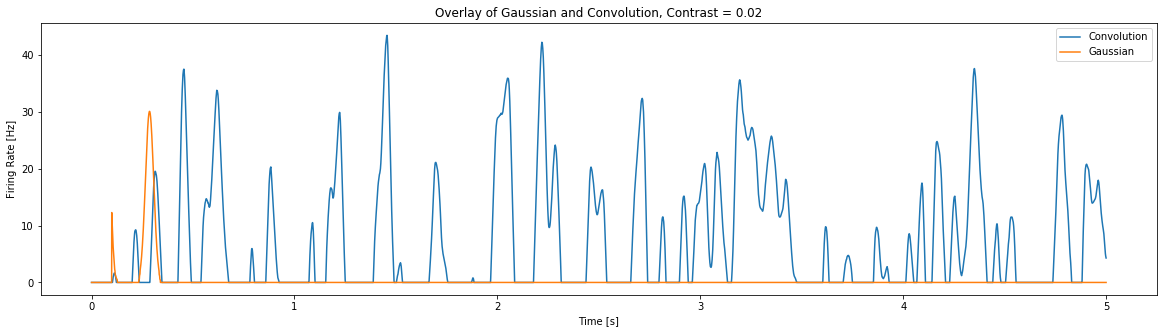

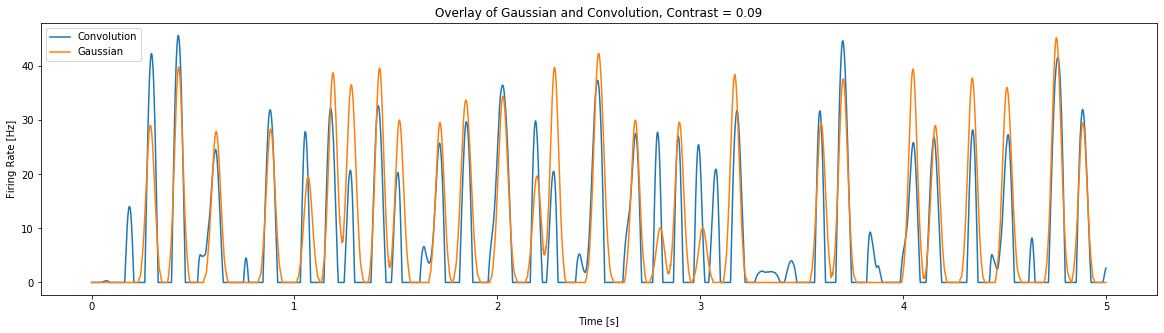

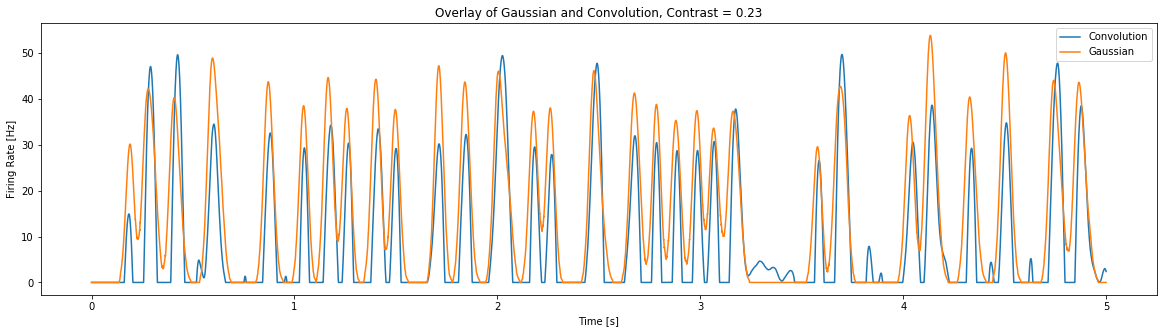

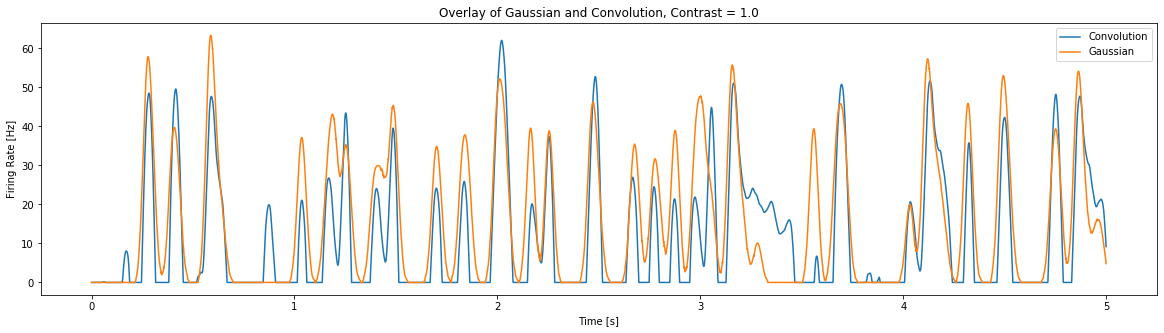

In [43]:
%matplotlib inline 

for n in [0,3,5,8]:
    
    gaussianData = gaussian_firing_list[n] 
    contrast = contrasts[0][n]                                        # contrast for that trial
    spikeTime = pd.DataFrame(spikeTimes[n][0],columns=["spikeTimes"]) # spike times for that trial

    convolution = convolution_function(n)
    convolutionZeros = list(map(zeroer,convolution))                  # set every term < 0 in convolution to 0
    
    times = np.linspace(0,5,10000)
    plt.figure(figsize=(20,5))
    plt.plot(times,convolutionZeros[:10000]/max(convolutionZeros)*max(gaussianData),label="Convolution")
    plt.plot(times,gaussianData[:10000],label="Gaussian")
    plt.xlabel("Time [s]")
    plt.ylabel("Firing Rate [Hz]")
    title = "Overlay of Gaussian and Convolution, Contrast = " + str(round(contrast,2))
    plt.title(title)
    plt.legend()

### 2c: Scatter plot 

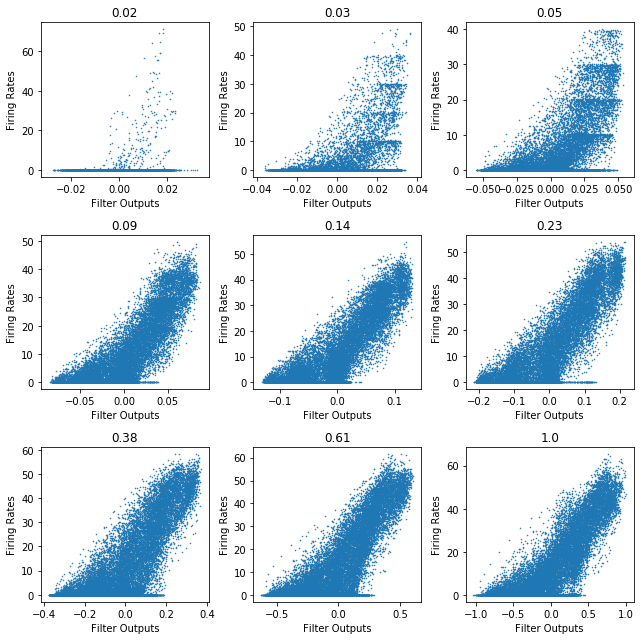

In [28]:
import matplotlib.gridspec as gridspec

%matplotlib inline 
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize=(9,9))

n = 0;

for i in range(0,3):                                                      #subplots generator
    for j in range(0,3):
        gaussianData = gaussian_firing_list[n]
        contrast = contrasts[0][n]                                        #contrast
        
        convolution = convolution_function(n)
        
        axs[i,j].scatter(convolution[0::10],gaussianData[0::10],s=0.3)    #plot every 10th point
        axs[i,j].set_ylabel("Firing Rates")
        axs[i,j].set_xlabel("Filter Outputs")
        
        title = str(round(contrast,2))
        axs[i,j].set_title(title)
        n += 1
        
plt.tight_layout()

### 2d: Average 

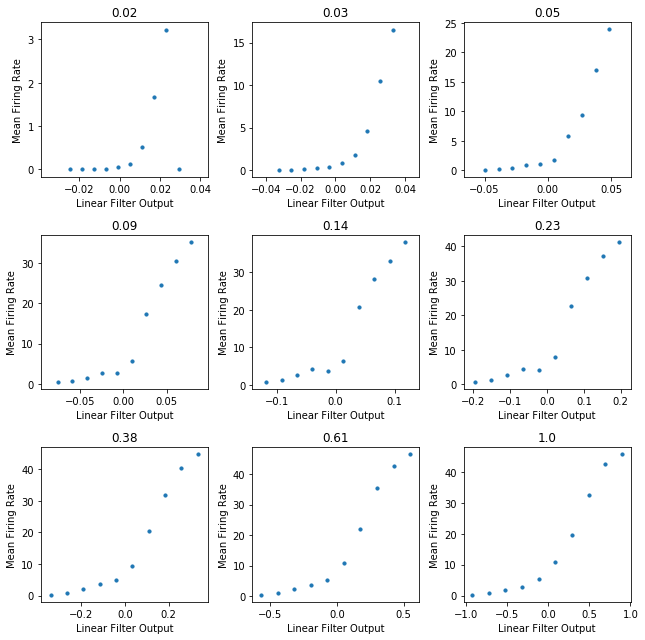

In [29]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize=(9,9))
points = 30                                                               #number of points in graph
n = 0;

for i in range(0,3):                                                      #subplots generator
    for j in range(0,3):
        gaussianData = gaussian_firing_list[n]
        contrast = contrasts[0][n]                                        #contrast
        spikeTime = pd.DataFrame(spikeTimes[n][0],columns=["spikeTimes"]) #spike times for that contrast
        
        convolution = convolution_function(n)                             #convolution
        
        convolution10 = convolution[0::10]                                #take every 10th point
        gaussian10 = gaussianData[0::10]                                  #take every 10th point
        
        yvals, bin_edges, bin_number = binned_statistic(convolution,gaussianData,statistic = "mean",bins=10)

        mid_bins = [(a + b) /2 for a,b in zip(bin_edges[:-1], bin_edges[1:])]      # find the center of each bin
        
        axs[i,j].scatter(mid_bins,yvals,s=10)
        title = str(round(contrast,2))
        axs[i,j].set_title(title)
        axs[i,j].set_ylabel("Mean Firing Rate")
        axs[i,j].set_xlabel("Linear Filter Output")
        n += 1
        
plt.tight_layout()

In observing the nonlinearities, the mean firing rate seems to start to plateau as the contrast gets higher. In addition, for all the contrasts, there doesn't seem to be a firing rate for filter outputs < 0.

### 2e: Interpolate 

In [30]:
"""
Interpolates between x and y points from 2d
"""

def interpolate(n):                                                            # returns interpolate function
    convolution = convolution_function(n)
    gaussianData = gaussian_firing_list[n]
    
    yvals, bin_edges, bin_number = binned_statistic(convolution,gaussianData,statistic = "mean",bins=10)
    mid_bins = [(a + b) /2 for a,b in zip(bin_edges[:-1], bin_edges[1:])]      # find the center of each bin
    
    return interp1d(mid_bins,yvals,fill_value='extrapolate')                   # return interpolation

In [31]:
"""
Graphs the predicted firing rate and the actual firing rate overlay (via interpolation function)
"""

def filter_grapher(n): 
    gaussianData = gaussian_firing_list[n]
    
    f = interpolate(n);
    xvals = convolution_function(n)
    nonlinear = f(xvals)
    
    contrast = contrasts[0][n] 
    
    plt.title(str(round(contrast,3)))
    plt.plot(nonlinear[:10000],label="Nonlinear Fit")
    plt.plot(gaussianData[:10000],label="Gaussian")
    plt.legend()

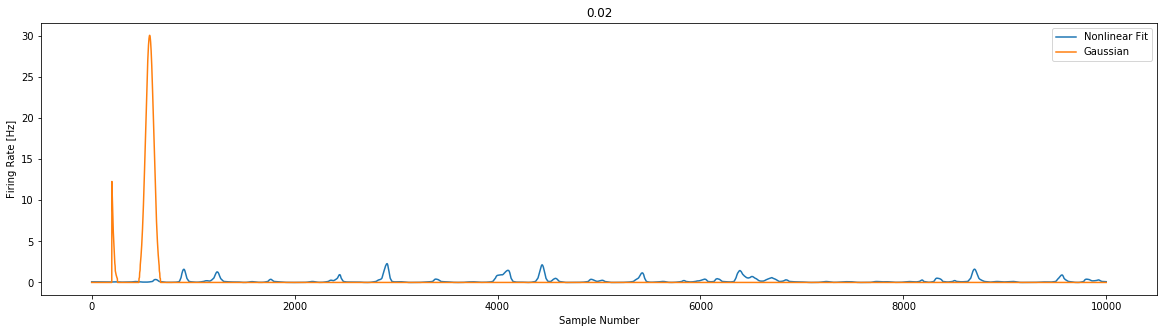

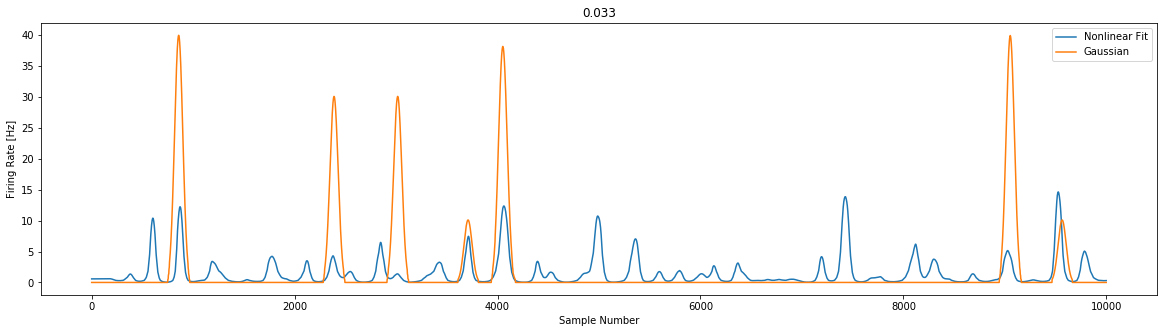

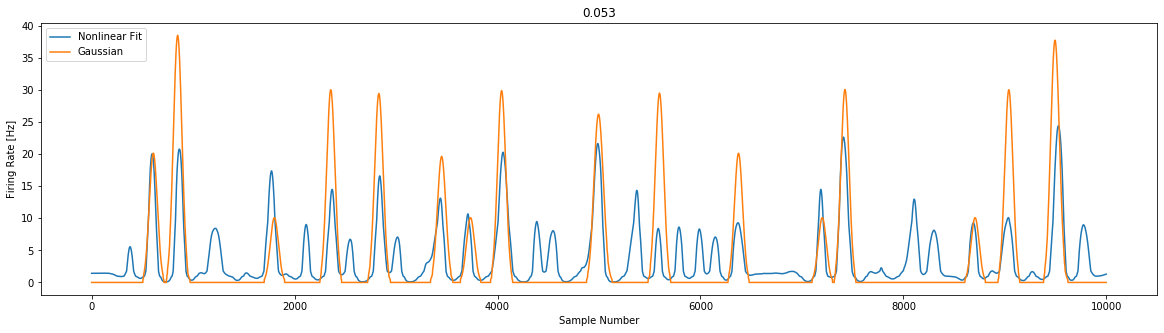

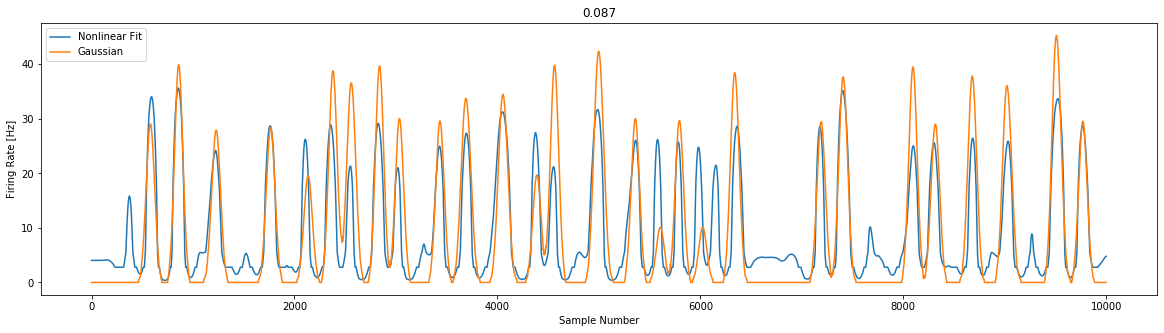

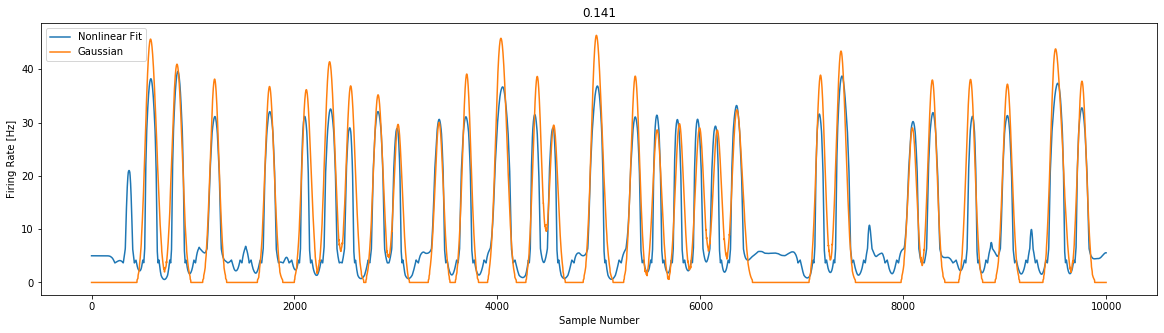

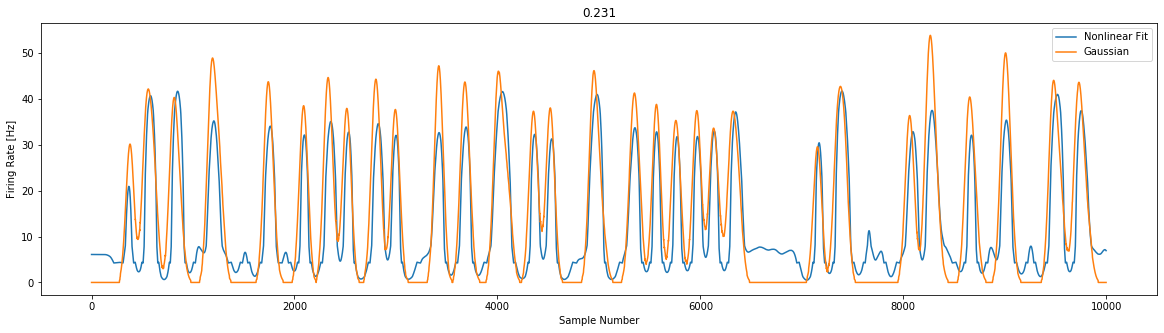

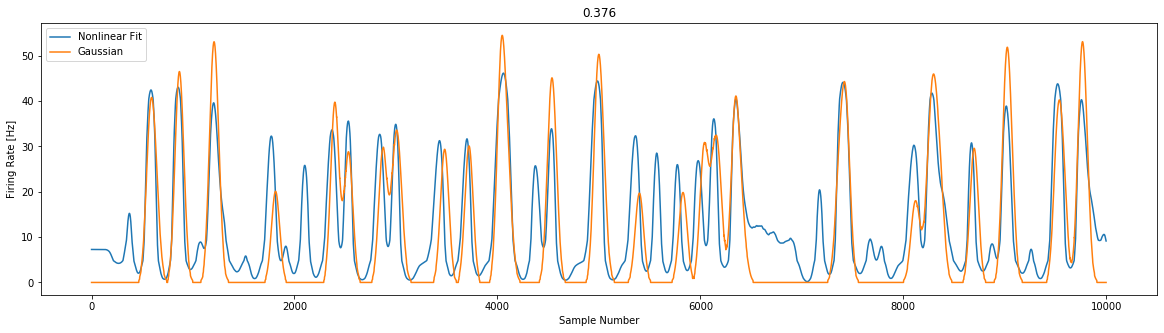

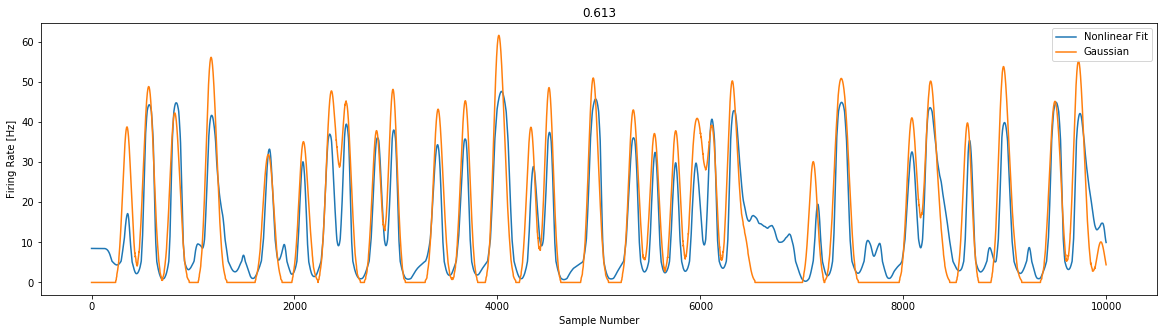

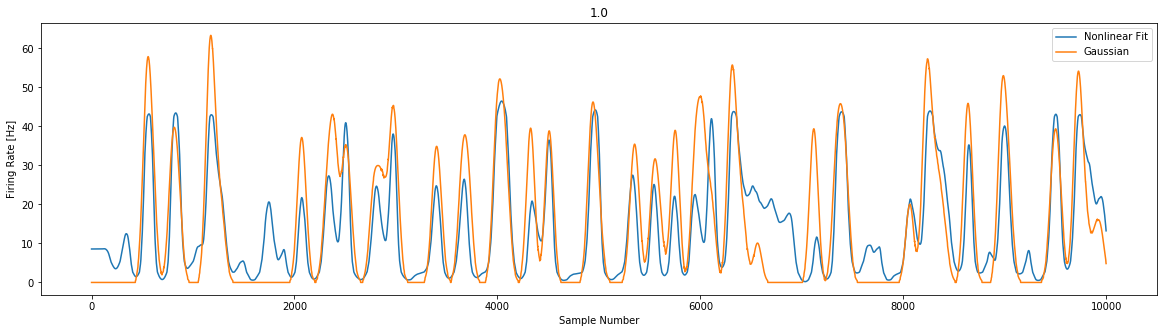

In [32]:
for n in range(9):
    plt.figure(figsize=(20,5));
    plt.xlabel("Sample Number")
    plt.ylabel("Firing Rate [Hz]")
    filter_grapher(n);

I would say that the nonlinear fit is a pretty fair description of a response of a neuron. It aligns pretty well with the peaks of the actual firing rate. However, for lower contrasts (i.e. less than 0.141)m the nonlinear fit starts to not align quite as well. I would say the absolute minimum viable contrast for this experiment would be around 0.05. The nonlinear firing rate for any contrast below that does not match up with the actual firing rate very well; the tfi are too low, and thus, the model cannot make good predictions of the firing.